The following code is used to demonstrate the result of pairwise rumor spread on a network. In this example, the network size is 400, with degree exponent of 2.5, and minimum degree of 3. The heatmap shows the stifler density with varying transmission rate while setting the threshold constant to 0.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import math as math
from math import log
import seaborn as sns
import pandas as pd

In [2]:
def generate_degree_sequence(n, gamma, kmin):
    # Generate a random set from the power law distribution
    u = np.random.uniform(size=n)
    degrees = np.ceil((1.0 - u) ** (-1.0 / (gamma - 1.0)))

    # Adjust degrees based on the minimum and maximum degree values
    kmax = int(np.sqrt(n))
    #kmax = int(1.5*n**(1/4)) # max degree allowed is 1.5*n^(1/4)
    degrees = degrees[(degrees >= kmin) & (degrees <= kmax)].astype(int)

    # Truncate or pad the sequence to match the length specified
    if len(degrees) >= n:
        degrees = degrees[:n]
    else:
        degrees = np.concatenate((degrees, np.full(n - len(degrees), kmin)))

    return degrees.tolist()

In [3]:
def Rumor_Basic(nw, lam, alp, n_samp):
   # initialize variables
    t_max = 10000
    #n_times = 100000  # number of time points at which rho_R is recorded and averaged
    #rho_R_av = np.zeros(n_times+1)  # Initialize rho_R_av as a numpy array of zeros
    #t_sav = np.zeros(n_times+1)  # Initialize t_sav as a numpy array of zeros
    #t_sav0 = 0
    N = len(nw.nodes)
    degrees = dict(nw.degree())
    kmax = max(degrees.values())

    t_end = 0
    stifler_fractions = []  # Initialize list to store stifler fractions


    for i_samp in range(1, n_samp+1):
        t = 0
        #n_sav = 0 # an index variable that keeps track of the current position in the rho_R_av array.
        #t_sav[n_sav] = t_sav0
        #rho_R = 0
        N_rec = 0

        # Initialize states with ignorant individuals
        states = {j: 0 for j in nw.nodes()}

        # Randomly select an initial spreader node
        inf = []
        initial_node = np.random.choice(list(nw.nodes()))
        states[initial_node] = 1
        inf.append(initial_node)
        N_inf = 1
        N_e = nw.degree(initial_node)

        while N_inf != 0:
            total_rate = lam * N_e + 2 * alp * N_e
            tau = -np.log(np.random.uniform(1e-6, 1)) / total_rate
            t += tau

            # Update average rho_R at specific time points
            #while n_sav < n_times and t > t_sav[n_sav]:
            #    rho_R_av[n_sav] += rho_R
            #    n_sav += 1
            #    t_sav[n_sav] += t_max/n_times


            if t >= t_max or lam == 0:
                break

            # Determine which event occurs
            event = np.random.uniform()
            p1 = lam / (lam + 2 * alp)
            p2 = (lam + alp )/ (lam + 2 * alp)

            # Determine if accept selected spreader based on degree distribution
            q_deg = np.random.uniform()

            # Infection event: I + S --> 2I
            if event <= p1:
                # Select a spreader individual to spread the rumor
                inf_node = np.random.choice(inf)
                if q_deg < degrees[inf_node]/kmax:
                  # Select a random neighbor to contact
                  neighbors = list(nw.neighbors(inf_node))
                  #if len(neighbors) > 0:
                  neighbor = np.random.choice(neighbors)
                  # Check if the selected neighbor is ignorant
                  if states[neighbor] == 0:
                        states[neighbor] = 1  # ignorant neighbor becomes spreader
                        inf.append(neighbor)
                        N_inf += 1
                        N_e += nw.degree(neighbor)

            else: # Recovery
                # Select a spreader individual to recover
                rec_node = np.random.choice(inf)
                if q_deg < degrees[rec_node]/kmax:
                    # Select a random neighbor to contact
                    neighbors = list(nw.neighbors(rec_node))
                    #if len(neighbors) > 0:
                    # Recover event 1:  I + R --> 2R
                    if event <= p2:
                        neighbor = np.random.choice(neighbors)
                        if states[neighbor] == 2:
                            # Update spreader to stifler if the selected neighbor is a stifler
                            states[rec_node] = 2
                            N_inf -= 1
                            N_e -= nw.degree(rec_node)
                            inf.remove(rec_node)
                            #rho_R += (1 / N)
                            N_rec += 1

                    else: # Recovery event 2: I + I --> R + I
                        neighbor = np.random.choice(neighbors)
                        if states[neighbor] == 1:
                            # Update spreader to stifler if the selected neighbor is a spreader
                            states[rec_node] = 2
                            N_inf -= 1
                            N_e -= nw.degree(rec_node)
                            inf.remove(rec_node)
                            #rho_R += (1 / N)
                            N_rec += 1


        if N_inf == 0:
            t_end += t
            stifler_frac = N_rec / N
            stifler_fractions.append(stifler_frac)
            print(lam, N_rec, t_end, stifler_frac)

        if lam == 0:
            t_end = 0
            stifler_frac = 0
            stifler_fractions.append(stifler_frac)
            print(lam, N_rec, t_end, stifler_frac)

        # Reset spreader and stiflers for the next sample
        #for node, state in states.items():
        #    if state == 1 or state == 2:
        #        states[node] = 0

    # Normalize the average rho_R values by dividing by the number of samples
    #rho_R_av /= n_samp
    #t_end_av = sum(t_end)/n_samp
    #rho_R_av = rho_R_end/n_samp
    avg_stifler_frac = sum(stifler_fractions) / len(stifler_fractions)
    t_end_av = t_end/n_samp

    return avg_stifler_frac, t_end_av

In [17]:
# Defines the parameters to be used
mu = 0.1
sigma = 0.05

# Function to assign thresholds to the individual nodes
def assign_thresholds(graph):
    NV = graph.size()
    Ltre = {}

    for node in graph.nodes():
          # Uniform distribution: #
          #Ltre[node] = np.random.uniform()
          # Normal distrution
          while True:
              threshold = random.gauss(mu, sigma)
              if 0 < threshold < 1:
                  break
          Ltre[node] = threshold

    return Ltre

n= 500
gamma = 2.5
kmin = 3
degrees = generate_degree_sequence(n, gamma, kmin)
nw = nx.configuration_model(degrees)

Ltre = assign_thresholds(nw)

print("Threshold List for Nodes: ", Ltre )

Threshold List for Nodes:  {0: 0.07217117154391431, 1: 0.043261221674361444, 2: 0.07284121063834187, 3: 0.13637837229965072, 4: 0.15650144773063723, 5: 0.09758180733214658, 6: 0.06846835278818371, 7: 0.16062283178342926, 8: 0.11543708951512532, 9: 0.00731068753551628, 10: 0.04217370283661738, 11: 0.07169635685220276, 12: 0.07715280675344861, 13: 0.11826787701996543, 14: 0.13460939239079697, 15: 0.20564286673564697, 16: 0.08395584242583479, 17: 0.09954197237803687, 18: 0.14601747397209994, 19: 0.1335553300190373, 20: 0.0950808753982752, 21: 0.04100630678041332, 22: 0.07604944452517189, 23: 0.037676291399663525, 24: 0.06654593264960515, 25: 0.1585615473516228, 26: 0.10754742547689326, 27: 0.1307443936422277, 28: 0.06348342879645953, 29: 0.03597965167682944, 30: 0.1733106406065102, 31: 0.12594681552461315, 32: 0.10175600922526834, 33: 0.05270884170763823, 34: 0.07569240940060737, 35: 0.14974636476895115, 36: 0.15669622162310154, 37: 0.05119659323193529, 38: 0.11941818123922607, 39: 0.1532

In [19]:
def Rumor_Basic_Threshold(nw, lam, alp, n_samp):
   # initialize variables
    t_max = 10000
    N = len(nw.nodes)
    degrees = dict(nw.degree())
    kmax = max(degrees.values())

    t_end = 0
    stifler_fractions = []  # Initialize list to store stifler fractions


    for i_samp in range(1, n_samp+1):
        t = 0
        #n_sav = 0 # an index variable that keeps track of the current position in the rho_R_av array.
        #t_sav[n_sav] = t_sav0
        #rho_R = 0
        N_rec = 0

        # Initialize states with ignorant individuals
        states = {j: 0 for j in nw.nodes()}

        # Randomly select an initial spreader node
        inf = []
        initial_node = np.random.choice(list(nw.nodes()))
        states[initial_node] = 1
        inf.append(initial_node)
        N_inf = 1
        N_e = nw.degree(initial_node)

        while N_inf != 0:
            total_rate = lam * N_e + 2 * alp * N_e
            tau = -np.log(np.random.uniform(1e-6, 1)) / total_rate
            t += tau

            # Update average rho_R at specific time points
            #while n_sav < n_times and t > t_sav[n_sav]:
            #    rho_R_av[n_sav] += rho_R
            #    n_sav += 1
            #    t_sav[n_sav] += t_max/n_times


            if t >= t_max or lam == 0:
                break

            # Determine which event occurs
            event = np.random.uniform()
            p1 = lam / (lam + 2 * alp)
            p2 = (lam + alp )/ (lam + 2 * alp)

            # Determine if accept selected spreader based on degree distribution
            q_deg = np.random.uniform()

            # Infection event: I + S --> 2I
            if event <= p1:
                # Select a spreader individual to spread the rumor
                inf_node = np.random.choice(inf)
                if q_deg < degrees[inf_node]/kmax:
                  # Select a random neighbor to contact
                  neighbors = list(nw.neighbors(inf_node))
                  #if len(neighbors) > 0:
                  neighbor = np.random.choice(neighbors)
                  # Check if the selected neighbor is ignorant
                  if states[neighbor] == 0:
                     count_inf_neighbors = sum(states[node] == 1 for node in nw.neighbors(neighbor))
                     if count_inf_neighbors / len(list(nw.neighbors(neighbor))) >= Ltre[neighbor]:
                        states[neighbor] = 1  # ignorant neighbor becomes spreader
                        inf.append(neighbor)
                        N_inf += 1
                        N_e += nw.degree(neighbor)

            else: # Recovery
                # Select a spreader individual to recover
                rec_node = np.random.choice(inf)
                if q_deg < degrees[rec_node]/kmax:
                    # Select a random neighbor to contact
                    neighbors = list(nw.neighbors(rec_node))
                    #if len(neighbors) > 0:
                    # Recover event 1:  I + R --> 2R
                    if event <= p2:
                        neighbor = np.random.choice(neighbors)
                        if states[neighbor] == 2:
                            # Update spreader to stifler if the selected neighbor is a stifler
                            states[rec_node] = 2
                            N_inf -= 1
                            N_e -= nw.degree(rec_node)
                            inf.remove(rec_node)
                            #rho_R += (1 / N)
                            N_rec += 1

                    else: # Recovery event 2: I + I --> R + I
                        neighbor = np.random.choice(neighbors)
                        if states[neighbor] == 1:
                            # Update spreader to stifler if the selected neighbor is a spreader
                            states[rec_node] = 2
                            N_inf -= 1
                            N_e -= nw.degree(rec_node)
                            inf.remove(rec_node)
                            #rho_R += (1 / N)
                            N_rec += 1


        if N_inf == 0:
            t_end += t
            stifler_frac = N_rec / N
            stifler_fractions.append(stifler_frac)
            print(lam, N_rec, t_end, stifler_frac)

        if lam == 0:
            t_end = 0
            stifler_frac = 0
            stifler_fractions.append(stifler_frac)
            print(lam, N_rec, t_end, stifler_frac)

        # Reset spreader and stiflers for the next sample
        #for node, state in states.items():
        #    if state == 1 or state == 2:
        #        states[node] = 0

    # Normalize the average rho_R values by dividing by the number of samples
    #rho_R_av /= n_samp
    #t_end_av = sum(t_end)/n_samp
    #rho_R_av = rho_R_end/n_samp
    avg_stifler_frac = sum(stifler_fractions) / len(stifler_fractions)
    t_end_av = t_end/n_samp

    return avg_stifler_frac, t_end_av

In [15]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
n= 500
gamma = 2.5
kmin = 3
degrees = generate_degree_sequence(n, gamma, kmin)
#print(degrees)
#nw = generate_configuration_model(degrees)
nw = nx.configuration_model(degrees)

alp = 1
n_samp = 500

# Set the mu and lambda_values
mu_values = np.arange(0.0, 0.1, 0.1)
lambda_values = np.arange(0.0, 5.1, 0.25)

# Initialize the result array
results = np.zeros((len(mu_values), len(lambda_values)))

# Iterate over mu and lambda values
for i, mu in enumerate(mu_values):
    for j, lam in enumerate(lambda_values):
        rho_R_av, t_end_av = Rumor_Basic(nw,  lam, alp, n_samp)
        results[i, j] = rho_R_av

df = pd.DataFrame(results)
df.to_csv('/content/drive/My Drive/Network_Tests/pairwise_big_new_lambda_range_0_5.csv')


Streaming output truncated to the last 5000 lines.
2.25 380 13170.953572719089 0.76
2.25 386 13203.195054312362 0.772
2.25 373 13232.873546500052 0.746
2.25 356 13269.433950221568 0.712
2.25 397 13294.052862517938 0.794
2.25 371 13317.028522851451 0.742
2.25 367 13338.759475150027 0.734
2.25 370 13388.821903301749 0.74
2.25 397 13411.509171925467 0.794
2.25 384 13439.973238491977 0.768
2.25 361 13465.15577907006 0.722
2.25 396 13499.49633772666 0.792
2.25 415 13518.65498063928 0.83
2.5 398 25.394374193807803 0.796
2.5 379 48.47328831847755 0.758
2.5 418 72.41018777154392 0.836
2.5 395 95.40708359665419 0.79
2.5 417 120.40547515588982 0.834
2.5 370 149.12516364339476 0.74
2.5 356 174.1499971471476 0.712
2.5 409 199.4370671594799 0.818
2.5 404 221.6948843800793 0.808
2.5 367 237.54789487048706 0.734
2.5 367 264.02634415056053 0.734
2.5 389 292.8338329191209 0.778
2.5 6 294.81035690158075 0.012
2.5 331 322.08711607376097 0.662
2.5 374 346.98891094134393 0.748
2.5 380 367.45656052309744 0.

In [22]:
n= 500
gamma = 2.5
kmin = 3
degrees = generate_degree_sequence(n, gamma, kmin)
#print(degrees)
#nw = generate_configuration_model(degrees)
nw = nx.configuration_model(degrees)

mu = 0.2
sigma = 0.1
Ltre = assign_thresholds(nw)

print("Threshold List for Nodes: ", Ltre )

alp = 1
n_samp = 500

# Set the mu and lambda_values
mu_values = np.arange(0.0, 0.1, 0.1)
lambda_values = np.arange(0.0, 5.1, 0.25)

# Initialize the result array
results = np.zeros((len(mu_values), len(lambda_values)))

# Iterate over mu and lambda values
for i, mu in enumerate(mu_values):
    for j, lam in enumerate(lambda_values):
        rho_R_av, t_end_av = Rumor_Basic_Threshold(nw,  lam, alp, n_samp)
        results[i, j] = rho_R_av

df = pd.DataFrame(results)
df.to_csv('/content/drive/My Drive/Network_Tests/pairwise_0_2.csv')


Streaming output truncated to the last 5000 lines.
2.5 2 12987.145107403856 0.004
2.5 168 13039.974526684744 0.336
2.5 273 13120.376876311186 0.546
2.5 7 13134.283549694203 0.014
2.5 200 13214.94957213492 0.4
2.5 4 13225.582939899352 0.008
2.5 5 13242.292459538321 0.01
2.5 2 13250.808217436153 0.004
2.5 114 13291.981832619971 0.228
2.5 4 13308.234197053012 0.008
2.5 144 13347.687186254489 0.288
2.5 300 13383.714556686837 0.6
2.5 128 13455.169550813736 0.256
2.5 28 13512.109167841678 0.056
2.5 54 13549.230351985605 0.108
2.5 118 13604.989060070133 0.236
2.5 53 13633.79567933956 0.106
2.5 143 13674.45471864318 0.286
2.5 9 13691.993761726973 0.018
2.5 154 13753.866382920869 0.308
2.5 34 13771.795610598847 0.068
2.5 3 13789.238835966771 0.006
2.5 235 13884.77335927836 0.47
2.5 96 13949.60381229336 0.192
2.5 3 13955.750837798441 0.006
2.5 153 14019.29555494477 0.306
2.5 2 14024.133623414114 0.004
2.5 4 14032.702656286221 0.008
2.5 37 14065.275948246717 0.074
2.5 32 14094.5790112812 0.064
2.

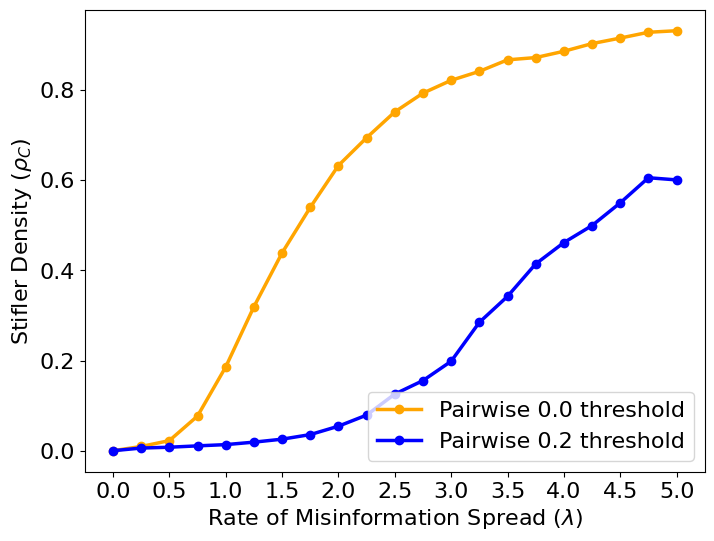

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV files
df1 = pd.read_csv('/content/drive/My Drive/Network_Tests/pairwise_big_new_lambda_range_0_5.csv', header=None)
df2 = pd.read_csv('/content/drive/My Drive/Network_Tests/pairwise_0_2.csv', header=None)
#df2 = pd.read_csv('/content/drive/My Drive/Network_Tests/hyperedge_big_new_lambda_range_0_5.csv', header=None)
#df3 = pd.read_csv('/content/drive/My Drive/Network_Tests/hyperedge_2_big_new_lambda_range_0_5.csv', header=None)

# Get the second row from each dataframe
data1 = df1.iloc[1].values[1:]  # skip the first column assuming it's non-numeric
data2 = df2.iloc[1].values[1:]  # skip the first column assuming it's non-numeric
#data3 = df3.iloc[1].values[1:]  # skip the first column assuming it's non-numeric

# Define the index values
#x = [i/10 for i in range(1, 10)]
x = np.arange(0.0, 5.1, 0.25)

fig, ax = plt.subplots(figsize=(8,6))
ax.set_xticks(np.arange(0.0, 5.1, 0.5))
#plt.xticks(rotation=45)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

# Plot the curves
plt.plot(x, data1, label='Pairwise 0.0 threshold',  marker='o', color = "orange",linestyle = "-", linewidth=2.5)
plt.plot(x, data2, label='Pairwise 0.2 threshold',  marker='o', color = "blue",linestyle = "-", linewidth=2.5)
#plt.plot(x, data2, label='Hyperedge 0.0 threshold',  marker='s', color = "red",linestyle = ":", linewidth=2.5)
#plt.plot(x, data3, label='Hyperedge 0.1 threshold', marker='p', color = "green",linestyle = "--", linewidth=2.5)

# Add title, labels, legend, and grid
# plt.title('Misinformation Spread in \n Pairwise vs Hyperedge Networks ($\gamma = 2.5$)', fontsize=16)
plt.xlabel(r'Rate of Misinformation Spread ($\lambda$)', fontsize=16)
plt.ylabel(r'Stifler Density ($\rho_C$)', fontsize=16)
plt.legend(loc=4, fontsize=16)

# Show the plot
plt.savefig('/content/drive/My Drive/Network_Tests/pairwise_0_0_versus_0_2.pdf')
plt.show()
